In [1]:
import json
import os
from pathlib import Path

from datasets import load_dataset
from tqdm.auto import tqdm
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, concatenate_datasets
import seaborn as sns

from hallucinations.datasets.utils import load_qa_metrics

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sns.set_theme("notebook")

In [2]:
dataset = load_dataset("google-research-datasets/nq_open")
dataset

Using the latest cached version of the dataset since google-research-datasets/nq_open couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'nq_open' at /home/jbinkowski/.cache/huggingface/datasets/google-research-datasets___nq_open/nq_open/0.0.0/5dd9790a83002ad084ddeb7c420dc716852c6f28 (last modified on Fri Oct  4 08:20:33 2024).


DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 87925
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 3610
    })
})

In [3]:
MODEL = "llama_3.1_8b_instruct"

results_dir = Path(f"data/activations/nq_open/{MODEL}/sampling_high_temp_with_activations__prompt_short_few_shot_sep__seed_42")
metrics = load_qa_metrics(results_dir)
metrics["llm_as_judge"] = metrics["llm_as_judge"].str.lower().str.replace(r"[^a-zA-Z]", "", regex=True)
metrics.head()

,prediction,gold,squad_f1,squad_exact_match,rougeL_fmeasure,rougeL_precision,rougeL_recall,llm_as_judge
0,"December 11, 1972, specifically the last time ...","[14 December 1972 UTC, December 1972]",0.266667,0.0,0.222222,0.125,1.0,incorrect
1,Bob Calvert.,"[Bobby Scott, Bob Russell]",0.500000,0.0,0.500000,0.500,0.5,incorrect
2,"I couldn't find any information on ""The Bastar...","[one, one season]",0.000000,0.0,0.000000,0.000,0.0,abstaining
3,"I'm sorry, I am unable to verify the year the ...",[2017],0.000000,0.0,0.000000,0.000,0.0,abstaining
4,I don't have access to real-time information o...,[South Carolina],0.000000,0.0,0.000000,0.000,0.0,abstaining


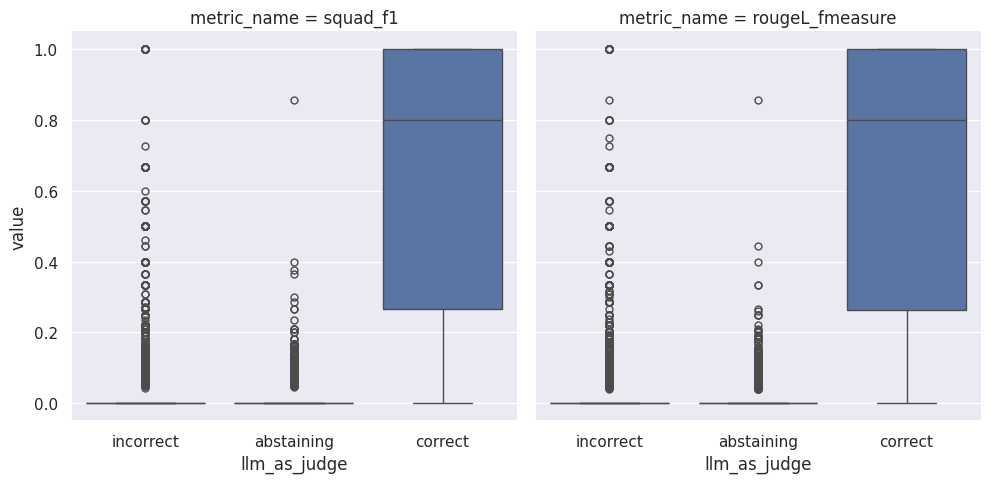

In [4]:
m_melt = metrics.melt(id_vars="llm_as_judge", value_vars=["squad_f1", "rougeL_fmeasure"], var_name="metric_name")
sns.catplot(data=m_melt, x="llm_as_judge", y="value", col="metric_name", kind="box")

In [5]:
# metrics.sort_values("rougeL_recall").head(20)
metrics[metrics["llm_as_judge"]=="abstaining"]

,prediction,gold,squad_f1,squad_exact_match,rougeL_fmeasure,rougeL_precision,rougeL_recall,llm_as_judge
2,"I couldn't find any information on ""The Bastar...","[one, one season]",0.000000,0.0,0.000000,0.000000,0.0,abstaining
3,"I'm sorry, I am unable to verify the year the ...",[2017],0.000000,0.0,0.000000,0.000000,0.0,abstaining
4,I don't have access to real-time information o...,[South Carolina],0.000000,0.0,0.000000,0.000000,0.0,abstaining
5,I couldn't find any information on when the Is...,[During the last Ice Age],0.162162,0.0,0.181818,0.102564,0.8,abstaining
11,I'm not aware of any information about the son...,[The Impalas],0.000000,0.0,0.095238,0.052632,0.5,abstaining
...,...,...,...,...,...,...,...,...
3585,I couldn't find any information about Forney's...,"[Margaret Hoard, Mary Elizabeth]",0.000000,0.0,0.000000,0.000000,0.0,abstaining
3590,"I'm sorry, but I cannot verify which current g...",[Karen Bradley],0.000000,0.0,0.000000,0.000000,0.0,abstaining
3599,I couldn't find specific information about the...,[1996],0.000000,0.0,0.000000,0.000000,0.0,abstaining
3606,New York University (NYU),"[New York University, Columbia University]",0.857143,0.0,0.857143,0.750000,1.0,abstaining


In [6]:
metrics[(metrics["llm_as_judge"] == "incorrect")].sort_values("rougeL_recall", ascending=False).head(20)

,prediction,gold,squad_f1,squad_exact_match,rougeL_fmeasure,rougeL_precision,rougeL_recall,llm_as_judge
3589,Alveolar.\n\n(It refers to the alveolar proces...,"[lamina dura, alveolar process, the lamina dura]",0.222222,0.0,0.190476,0.105263,1.0,incorrect
0,"December 11, 1972, specifically the last time ...","[14 December 1972 UTC, December 1972]",0.266667,0.0,0.222222,0.125000,1.0,incorrect
3587,"The Tower of London was completed in 1100, but...",[1078],0.083333,0.0,0.076923,0.040000,1.0,incorrect
3580,Lighter fluid.,"[lighter fluid, butane]",1.000000,1.0,1.000000,1.000000,1.0,incorrect
226,Lateral geniculate nucleus of the thalamus the...,"[pretectal nucleus, suprachiasmatic nucleus, p...",0.400000,0.0,0.333333,0.200000,1.0,incorrect
220,"Alyssa Milano, Josh Charles, Polly Draper","[Kimmy Robertson, Jeff Bollow, John Getz, Keit...",0.500000,0.0,0.500000,0.333333,1.0,incorrect
3136,Egypt and Israel.,[Egypt],0.500000,0.0,0.500000,0.333333,1.0,incorrect
3255,"Algeria, Angola, Benin's Autonomy (a disputed ...","[Algeria‎, Algeria, Angola‎, Angola]",0.076923,0.0,0.066667,0.034483,1.0,incorrect
3234,That alteration finds what it alters. (Shakesp...,[Sonnet 116],0.363636,0.0,0.363636,0.222222,1.0,incorrect
3233,2-4 days after birth.,"[at birth, birth]",0.400000,0.0,0.333333,0.200000,1.0,incorrect
